In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn import svm

In [2]:
# 1. Perform data cleaning.
# Reading data in pandas dataframe
df = pd.read_table('H:/Assignment6/iwpc_warfarin.txt', sep='\t')
print(df.columns)
print("Length of Columns=", len(df.columns))
print(df.shape)
df.head(3)
df.info()

Index(['PharmGKB Subject ID', 'PharmGKB Sample ID', 'Project Site', 'Gender',
       'Race (Reported)', 'Race (OMB)', 'Ethnicity (Reported)',
       'Ethnicity (OMB)', 'Age', 'Height (cm)', 'Weight (kg)',
       'Indication for Warfarin Treatment', 'Comorbidities', 'Medications',
       'Target INR', 'Estimated Target INR Range Based on Indication',
       'Subject Reached Stable Dose of Warfarin',
       'Therapeutic Dose of Warfarin',
       'INR on Reported Therapeutic Dose of Warfarin', 'Current Smoker',
       'CYP2C9 consensus', 'VKORC1 -1639 consensus'],
      dtype='object')
Length of Columns= 22
(5700, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 22 columns):
PharmGKB Subject ID                               5700 non-null object
PharmGKB Sample ID                                5700 non-null object
Project Site                                      5700 non-null int64
Gender                                            5696 non

In [3]:
# Removing the date error
print("Age", pd.unique(df['Age']))
print("Gender", pd.unique(df['Gender']))
print("Comorbidities",pd.unique(df['Comorbidities']))
print("Target INR",pd.unique(df['Target INR']))
print("Race (OMB)",pd.unique(df['Race (OMB)']))
print("Estimated Target INR Range Based on Indication",pd.unique(df['Estimated Target INR Range Based on Indication']))
print("Medications",pd.unique(df['Medications']))
print("Indication for Warfarin Treatment",pd.unique(df['Indication for Warfarin Treatment']))
print("Ethnicity (OMB)",pd.unique(df['Ethnicity (OMB)']))

df['Age'] = df['Age'].replace('19-Oct','10-19')
df['Estimated Target INR Range Based on Indication'] = df['Estimated Target INR Range Based on Indication'].replace('4-Mar','3.0-4.0')
df['Estimated Target INR Range Based on Indication'] = df['Estimated Target INR Range Based on Indication'].replace('3-Feb','2.0-3.0')

print("After fixing date error")
print("Age", pd.unique(df['Age']))
print("Estimated Target INR Range Based on Indication",pd.unique(df['Estimated Target INR Range Based on Indication']))

Age ['60 - 69' '50 - 59' '40 - 49' '70 - 79' '30 - 39' '80 - 89' '90+'
 '20 - 29' '19-Oct' nan]
Gender ['male' 'female' nan]
Comorbidities ['No Cancer' 'Cancer' nan ...,
 'high cholesterol; atrial fibrilation; congestive heart failure; coronary artery disease; myocardial infarction; coronary artery bypass surgery; stent; diabetes mellitus; renal insufficiency'
 'hypertension; high cholesterol; congestive heart failure; coronary artery disease; diabetes mellitus; renal insufficiency'
 'hypertension; high cholesterol; cancer']
Target INR [ 2.5   3.    2.    2.2   3.25  3.5   2.8   2.7   2.3   2.6   1.3   1.75
   nan]
Race (OMB) ['White' 'Unknown' 'Black or African American' 'Asian']
Estimated Target INR Range Based on Indication [nan '1.7-3.3' '3-Feb' '2-3.5' '1.7-2.8' '2.5-3.5' '3.0-4.0' '4-Mar']
Medications ['aspirin; not simvastatin; not amiodarone'
 'not aspirin; not simvastatin; not amiodarone'
 'not aspirin; simvastatin; not amiodarone' ...,
 'Aspirin and/or palvix and/or  dipyrida

In [4]:
# Getting the dataset ready for ML
df.Age = pd.to_numeric(df.Age.str[0])
print(pd.unique(df.Age))
#         df.loc[index, 'Medications'] = 0
#         df.loc[index, 'Medications'] = 1

# Make medication column boolean
# Use vector
# 3 passes-> not and no 
print(pd.unique(df.Medications))
# ddf = df.[]

# for index, value in enumerate(df.Medications):
#     if "not amiodarone" in value:
#         df.loc[index, 'Medications'] = 0
#     else if:
#         df.loc[index, 'Medications'] = 1
print(pd.unique(df.Medications))      

[  6.   5.   4.   7.   3.   8.   9.   2.   1.  nan]
['aspirin; not simvastatin; not amiodarone'
 'not aspirin; not simvastatin; not amiodarone'
 'not aspirin; simvastatin; not amiodarone' ...,
 'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone'
 'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone; statin'
 'Aspirin and/or palvix and/or  dipyridamole; substrate2c9']
['aspirin; not simvastatin; not amiodarone'
 'not aspirin; not simvastatin; not amiodarone'
 'not aspirin; simvastatin; not amiodarone' ...,
 'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone'
 'Aspirin and/or palvix and/or  dipyridamole; inhibit2c9; amiodarone; statin'
 'Aspirin and/or palvix and/or  dipyridamole; substrate2c9']


In [5]:
# 2. Create two subsets for further exploration: a subset for patients with high warfarin dosage
# (0.2 or more standard deviations above the mean) and a subset for patients with low warfarin
# dosage (0.2 or more standard deviations below the mean)

df['Therapeutic Dose of Warfarin'].describe()
warfarin = df['Therapeutic Dose of Warfarin']
meanwd = pd.DataFrame.mean(warfarin)
hwd = pd.DataFrame.mean(warfarin) + 0.2*pd.DataFrame.std(warfarin) #Ask Professor 
lwd = pd.DataFrame.mean(warfarin) - 0.2*pd.DataFrame.std(warfarin)
print(meanwd)
print(hwd)
print(lwd)
hwdf = df[(df['Therapeutic Dose of Warfarin'] >= hwd)]
lwdf = df[(df['Therapeutic Dose of Warfarin'] <= lwd)]

print("High Warfarin dosage=", hwdf.shape)
print("Low warfarin dosage=", lwdf.shape)
hwdf.head(2)

#rowbind in pandas 

30.97787264833573
34.338080656214686
27.61766464045677
High Warfarin dosage= (2044, 22)
Low warfarin dosage= (2654, 22)


,PharmGKB Subject ID,PharmGKB Sample ID,Project Site,Gender,Race (Reported),Race (OMB),Ethnicity (Reported),Ethnicity (OMB),Age,Height (cm),...,Comorbidities,Medications,Target INR,Estimated Target INR Range Based on Indication,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker,CYP2C9 consensus,VKORC1 -1639 consensus
0,PA135312261,PA135312629,1,male,White,White,not Hispanic or Latino,not Hispanic or Latino,6.0,193.04,...,No Cancer,aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,49.0,2.60,0.0,*1/*1,A/G
1,PA135312262,PA135312630,1,female,White,White,not Hispanic or Latino,not Hispanic or Latino,5.0,176.53,...,Cancer,not aspirin; not simvastatin; not amiodarone,2.5,NaN,1.0,42.0,2.15,1.0,*1/*1,A/A


In [6]:
# 3. Display aggregate information on the data (ex: summary in R or describe in Pandas. You may
df.describe()
# hwdf.describe()
# lwdf.describe()

,Project Site,Age,Height (cm),Weight (kg),Target INR,Subject Reached Stable Dose of Warfarin,Therapeutic Dose of Warfarin,INR on Reported Therapeutic Dose of Warfarin,Current Smoker
count,5700.000000,5658.000000,4554.000000,5413.000000,1259.000000,5651.000000,5528.000000,4968.000000,3220.000000
mean,9.555965,5.924001,168.047811,77.853057,2.538324,0.960007,30.977873,2.364436,0.139441
std,6.340864,1.473190,10.846051,21.860018,0.198140,0.195960,16.801040,0.464645,0.346460
min,1.000000,1.000000,124.970000,30.000000,1.300000,0.000000,2.100000,0.800000,0.000000
25%,4.000000,5.000000,160.020000,62.000000,2.500000,1.000000,19.530000,2.100000,0.000000
50%,8.000000,6.000000,167.890000,75.000000,2.500000,1.000000,28.000000,2.400000,0.000000
75%,15.000000,7.000000,176.020000,90.000000,2.500000,1.000000,38.500000,2.610000,0.000000
max,21.000000,9.000000,202.000000,237.700000,3.500000,1.000000,315.000000,6.100000,1.000000


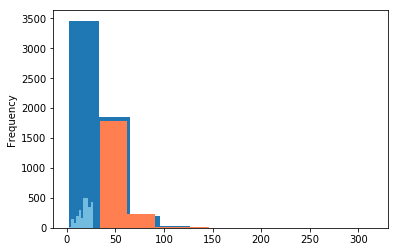

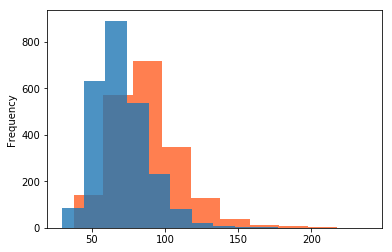

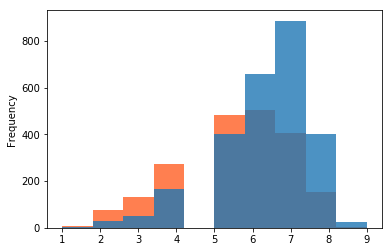

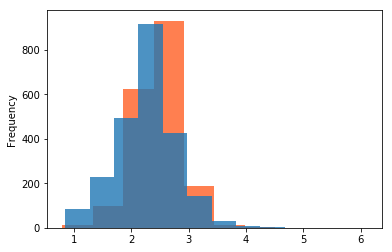

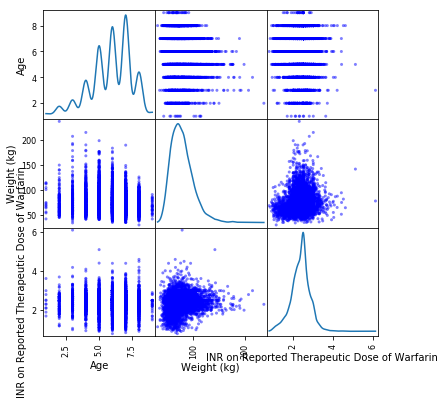

In [7]:
# 4. Create visualizations of the distributions of key variables by high/low warfarin dosage.

df_plot = df['Therapeutic Dose of Warfarin']
df_plot.plot.hist()
df_plot = hwdf['Therapeutic Dose of Warfarin']
df_plot.plot.hist(color='coral')
df_plot = lwdf['Therapeutic Dose of Warfarin']
df_plot.plot.hist(color='skyblue', alpha=0.8)
plt.show()

df_plot = hwdf['Weight (kg)']
df_plot.plot.hist(color='coral')
df_plot = lwdf['Weight (kg)']
df_plot.plot.hist(alpha=0.8)
plt.show()

df_plot = hwdf['Age']
df_plot.plot.hist(color='coral')
df_plot = lwdf['Age']
df_plot.plot.hist(alpha=0.8)
plt.show()

df_plot = hwdf['INR on Reported Therapeutic Dose of Warfarin']
df_plot.plot.hist(color='coral')
df_plot = lwdf['INR on Reported Therapeutic Dose of Warfarin']
df_plot.plot.hist(alpha=0.8)
plt.show()

df_plot = df[['Age', 'Weight (kg)','INR on Reported Therapeutic Dose of Warfarin' ]]
scatter_matrix(df_plot, alpha=0.5, figsize=(6, 6), diagonal='kde', color="blue")
plt.show()

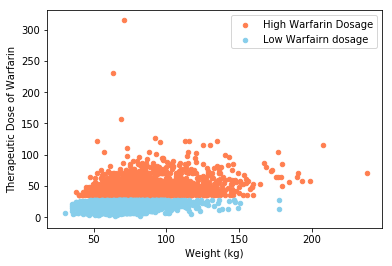

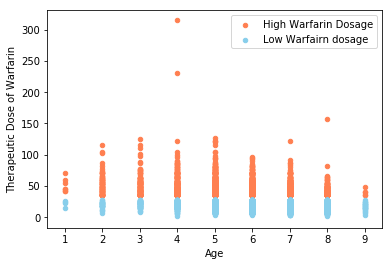

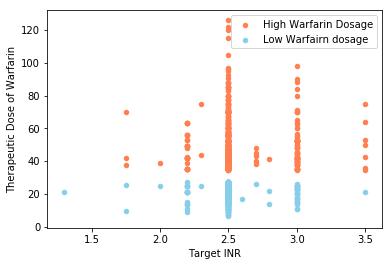

In [8]:
# 5. Create visualizations of a couple of relationships you find interesting between variables
# (ex: scatter plot colored by high/low warfarin dosage).
# Bar plot with race vs Genotypes
ax = hwdf.plot.scatter(x='Weight (kg)', y='Therapeutic Dose of Warfarin', color='coral', label='High Warfarin Dosage')
lwdf.plot.scatter(x='Weight (kg)', y='Therapeutic Dose of Warfarin', color='skyblue', label='Low Warfairn dosage', ax=ax)
plt.show()

ax = hwdf.plot.scatter(x='Age', y='Therapeutic Dose of Warfarin', color='coral', label='High Warfarin Dosage')
lwdf.plot.scatter(x='Age', y='Therapeutic Dose of Warfarin', color='skyblue', label='Low Warfairn dosage', ax=ax)
plt.show()

ax = hwdf.plot.scatter(x='Target INR', y='Therapeutic Dose of Warfarin', color='coral', label='High Warfarin Dosage')
lwdf.plot.scatter(x='Target INR', y='Therapeutic Dose of Warfarin', color='skyblue', label='Low Warfairn dosage', ax=ax)
plt.show()

In [9]:
# 6. Fit 2 regression models, as described below, to estimate warfarin dosage.
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# 2 more columns --> fit in the model
# Preparing training and testing set
def preprocess_data (df):
    df = df.drop(['PharmGKB Subject ID', 'PharmGKB Sample ID', 'Project Site', 'Race (Reported)', 
                  'Ethnicity (Reported)', 'Height (cm)', 'Indication for Warfarin Treatment', 'Comorbidities', 
                  'Current Smoker','Subject Reached Stable Dose of Warfarin',
                  'Estimated Target INR Range Based on Indication', 'Medications'
                 , 'Target INR', 'INR on Reported Therapeutic Dose of Warfarin'], axis=1)

    df_wna = df.dropna()
    print("Shape after dropping nas=", df_wna.shape)
    df_obj = df_wna.select_dtypes(include=[object])
    print(df_obj.head(3))

    # 1. INSTANTIATE to encode labels with value between 0 and n_classes-1.
    le = preprocessing.LabelEncoder()
    print(df_obj.shape)
    print(df_obj.info())

    # 2, 3. FIT AND TRANSFORM
    # use df.apply() to apply le.fit_transform to all columns
    df_obj = df_wna.apply(le.fit_transform)
    print(df_wna.shape)
    print (df_wna.head())
    print(df_wna.info())

    enc = preprocessing.OneHotEncoder(sparse=False)
    enc.fit(df_obj)
    onehotlabels = enc.transform(df_obj)
    print(df_obj.shape)
    print(df_obj.head(5))
    return df_obj

In [10]:
#Preprocess data
df_obj = preprocess_data(df)

Shape after dropping nas= (3760, 8)
   Gender Race (OMB)         Ethnicity (OMB) CYP2C9 consensus  \
0    male      White  not Hispanic or Latino            *1/*1   
1  female      White  not Hispanic or Latino            *1/*1   
2  female      White  not Hispanic or Latino            *1/*1   

  VKORC1 -1639 consensus  
0                    A/G  
1                    A/A  
2                    G/G  
(3760, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3760 entries, 0 to 5686
Data columns (total 5 columns):
Gender                    3760 non-null object
Race (OMB)                3760 non-null object
Ethnicity (OMB)           3760 non-null object
CYP2C9 consensus          3760 non-null object
VKORC1 -1639 consensus    3760 non-null object
dtypes: object(5)
memory usage: 176.2+ KB
None
(3760, 8)
   Gender Race (OMB)         Ethnicity (OMB)  Age  Weight (kg)  \
0    male      White  not Hispanic or Latino  6.0        115.7   
1  female      White  not Hispanic or Latino  5.0      

In [11]:
#Dropping nas
df_unique = df_obj.dropna()
X = df_unique.drop('Therapeutic Dose of Warfarin', axis=1)
y = df_unique['Therapeutic Dose of Warfarin']
print("Training set", X.columns)
print(len(X))
print(X.head())
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=50)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Training set Index(['Gender', 'Race (OMB)', 'Ethnicity (OMB)', 'Age', 'Weight (kg)',
       'CYP2C9 consensus', 'VKORC1 -1639 consensus'],
      dtype='object')
3760
   Gender  Race (OMB)  Ethnicity (OMB)  Age  Weight (kg)  CYP2C9 consensus  \
0       1           3                2    5          481                 0   
1       0           3                2    4          556                 0   
2       0           3                2    3          243                 0   
3       1           3                2    5          346                 0   
4       1           3                2    4          211                 5   

   VKORC1 -1639 consensus  
0                       1  
1                       0  
2                       2  
3                       1  
4                       1  
(3384, 7) (3384,)
(376, 7) (376,)


Coefficients: 
 [ -1.45333428   4.9010816   16.69091834 -15.01156808   0.14533991
  -9.30241601  51.39947901]
Mean squared error: 3233.10
Variance score: 0.50
(3384, 7)
(376,)


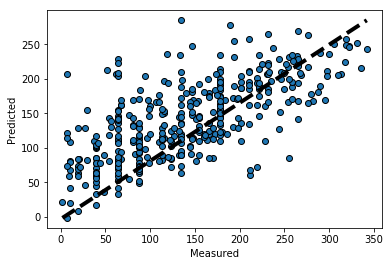

In [12]:
# Model 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# How to plot?
# # # # Plot outputs
print(X_train.shape)
print(y_test.shape)

# Cross validated scores
predicted = cross_val_predict(regr, X_test, y_test, cv=10)
fig, ax = plt.subplots()
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [predicted.min(), predicted.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Coefficients: 
 [-0.08847732  0.28748139  0.63436605 -0.66455742  0.00644796 -0.43350978
  2.25679154]
Mean squared error: 6.99
Variance score: 0.48


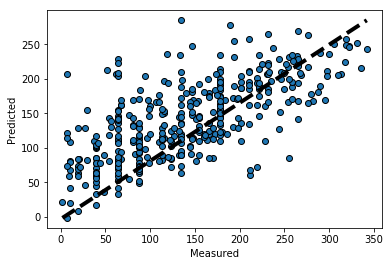

In [13]:
# Model 2
# Taking square root of the y_test and y_train : 
# replacing response variable therapeutic warfarin dose with square root of therapeutic warfarin dose.
y_train_sqrt = np.sqrt(y_train)
y_test_sqrt = np.sqrt(y_test)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train_sqrt)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test_sqrt, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test_sqrt, y_pred))

# Cross validated scores
predicted = cross_val_predict(regr, X_test, y_test, cv=10)

fig, ax = plt.subplots()
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [predicted.min(), predicted.max()], 'k--', lw=4) # random predictions line, 50% accuracy
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [14]:
# Getting data ready for SVM
# print(hwdf.info())
# print(lwdf.info())

hwdf.loc[:,('Therapeutic Dose of Warfarin')] = 1    
lwdf.loc[:,('Therapeutic Dose of Warfarin')] = 0
    
print(pd.unique(hwdf['Therapeutic Dose of Warfarin']))
print(pd.unique(lwdf['Therapeutic Dose of Warfarin']))

frames = [hwdf, lwdf]
result = pd.concat(frames)
result.describe()
print(result.head(3))
print(pd.unique(result['Therapeutic Dose of Warfarin']))

p_data = preprocess_data(result)


[1]
[0]
  PharmGKB Subject ID PharmGKB Sample ID  Project Site  Gender  \
0         PA135312261        PA135312629             1    male   
1         PA135312262        PA135312630             1  female   
2         PA135312263        PA135312631             1  female   

  Race (Reported) Race (OMB)    Ethnicity (Reported)         Ethnicity (OMB)  \
0           White      White  not Hispanic or Latino  not Hispanic or Latino   
1           White      White  not Hispanic or Latino  not Hispanic or Latino   
2           White      White  not Hispanic or Latino  not Hispanic or Latino   

   Age  Height (cm)           ...            Comorbidities  \
0  6.0       193.04           ...                No Cancer   
1  5.0       176.53           ...                   Cancer   
2  4.0       162.56           ...                No Cancer   

                                    Medications Target INR  \
0      aspirin; not simvastatin; not amiodarone        2.5   
1  not aspirin; not simvastatin; 

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
df_unique = p_data.dropna()
X = df_unique.drop('Therapeutic Dose of Warfarin', axis=1)
y = df_unique['Therapeutic Dose of Warfarin']
print("Training set:", X.columns)
print("Test set:", y.name)

print(len(X))
print(X.head())
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=50)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Training set: Index(['Gender', 'Race (OMB)', 'Ethnicity (OMB)', 'Age', 'Weight (kg)',
       'CYP2C9 consensus', 'VKORC1 -1639 consensus'],
      dtype='object')
Test set: Therapeutic Dose of Warfarin
3179
   Gender  Race (OMB)  Ethnicity (OMB)  Age  Weight (kg)  CYP2C9 consensus  \
0       1           3                2    5          455                 0   
1       0           3                2    4          525                 0   
2       0           3                2    3          230                 0   
4       1           3                2    4          198                 5   
5       1           3                2    3          402                 0   

   VKORC1 -1639 consensus  
0                       1  
1                       0  
2                       2  
4                       1  
5                       2  
(2861, 7) (2861,)
(318, 7) (318,)


In [21]:
# # 7. Fit an SVM model to classify patients into categories of high/low warfarin dosage
C = 1.0  # SVM regularization parameter

model = svm.SVC(kernel='linear', C=C, probability=True)
svm_fit = model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [22]:
# Accuracy of Linear SVM
svmScore = model.score(X_test, y_test)
print("Accuracy of Linear SVM = ", svmScore*100)
# Confusion matrix analysis
cm = confusion_matrix(y_test, y_predict)
print(cm)

Accuracy of Linear SVM =  83.0188679245
[[152  30]
 [ 24 112]]


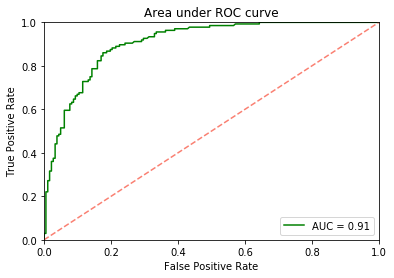

In [23]:
#Area under ROC with predict probas
probas_ = svm_fit.predict_proba(X_test)
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

# print(probas_)
# Plot ROC curve
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color="green")

plt.plot([0, 1], [0, 1], 'k--', color="salmon")  # random predictions curve, 50% accuracy
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Area under ROC curve')
plt.legend(loc="lower right")
plt.show()